# **Task 1:  Sequence Tagging with RNNs**

In this task, you will implement LSTM and Bi-LSTM architectures with PyTorch to perform part-of-speech tagging (a sequence tagging task).

### **Data**
We use a subset of the data from the CoNLL-2003 shared task on Named Entity Recognition (provided in the zip). It is pre-partioned into a training, development and test set.

The dataset consists of pre-tokenized sentences where every token is annotated with a part-of-speech tag, a syntactic chunk tag and a named entity tag. In this home exercise, we only use the IOB named entity recognition tag.

In [1]:
import torch
import torch.nn as nn
import os
import re
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random

In [3]:
def seed_everything(seed: int):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type(torch.FloatTensor) #added to avoid datatype problems

seed_everything(seed=999)

## **Task 1.1: Pretrained Embeddings (5p)**

Download the pretrained, uncased GloVe embeddings with 6B tokens [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) from Stanford.

For performance reasons, we will only use the 50-dimensional embeddings **glove.6B.50d.txt**.

Implement a function to read the embedding and another function to read the dataset.

#### Data Pre-processing

In [5]:
# https://medium.com/analytics-vidhya/ner-tensorflow-2-2-0-9f10dcf5a0a
def split_text_label(filename):
  """ Store each sentence seperately. Each token of the sentences is stored with its corresponding 
      IOB named entity recognition tag """
  f = open(filename)
  split_labeled_text = []
  sentence = []
  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
       if len(sentence) > 0:
         split_labeled_text.append(sentence)
         sentence = []
       continue
    splits = line.split(' ')
    sentence.append([splits[0],splits[-1].rstrip("\n")])
  if len(sentence) > 0:
    split_labeled_text.append(sentence)
    sentence = []
  return split_labeled_text

In [7]:
def read_data(path):
    """
      Given a path, return 2 dictionaries where the key is a progressive integer 
      and the value is a list of words or IOB tags.:
    """
    data = defaultdict(list)
    label = defaultdict(list)
    
    # TODO: YOUR CODE HERE
    text_label = split_text_label(filename=path)
    for idx, sent in enumerate(text_label):
      words = []
      iob_labels = []
      for word_iob in sent:
        words.append(word_iob[0]) #add word
        iob_labels.append(word_iob[1]) #add iob tag

      data[idx] = words
      label[idx] = iob_labels

    return data, label

def get_pretrained_embeddings(embedding_path):
    """
      Given a path, return a dictionary where the key is a word and the value is the corresponding embeddibng vector
    """
    embeddings = defaultdict(list)
    # TODO: YOUR CODE HERE
    
    with open(embedding_path, "r") as f:
      for line in f:
        line = line.strip()
        word = line.split(" ")[0]
        vector = np.array([float(n) for n in line.split(" ")[1:]])

        embeddings[word] = vector

    return embeddings

#### Tests

In [37]:
# Dataset's path
emb_path = 'data/glove.6B/glove.6B.50d.txt'
data_path = 'data/ner_eng_bio.train'

In [38]:
split_labeled_text = split_text_label(data_path)
print(split_labeled_text[0])

[['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [39]:
data, labels = read_data(data_path)
emb = get_pretrained_embeddings(emb_path)

In [41]:
data[0], labels[0], emb['the']

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'],
 array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]))

In [26]:
print("Word: ", data[0][2])
print("BIO tag: ", labels[0][2])
test_word = data[0][2].lower()
print("Embedding for ", test_word, ": ", emb[test_word])

Word:  LEICESTERSHIRE
BIO tag:  B-ORG
Embedding for  leicestershire :  [-1.1941   -0.662    -0.99443  -0.29622  -0.043578 -0.027623  0.32742
  0.72644   0.34452  -0.74695  -0.88149   0.10591  -0.29908  -2.1368
 -1.0025   -0.20246   0.88068   0.57094  -1.2529    0.89194   0.29749
  0.13429   0.85126   0.59227  -0.5394   -0.099542  0.62803  -0.3396
 -0.4139   -0.098723  0.4635    0.17274   1.3615    0.33736   1.3339
  0.47204   0.54279  -0.24796  -0.33685  -0.57576   0.029242 -0.52537
 -0.79114   0.27962  -0.53181   1.0727   -0.62831  -0.25348   0.61433
 -0.18755 ]


## **Task 1.2: LSTM and Bi-LSTM Model (10p)**

We will use PyTorch to build our LSTM. Complete the `__init__()` and the `forward()` function of the CustomLSTM class. The model will have the following components:
- A single [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer which takes the embeddings as input and has 100-dimensional hidden layer. The LSTM is **not** bidirectional.
- A dropout layer with probability 0.1
- A linear layer with input size of 100 (the hidden layer size of the LSTM layer) and output size of the number of labels
- A [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function

In [12]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_labels):
        super(CustomLSTM, self).__init__()
        
        # TODO: YOUR CODE HERE        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_labels = num_labels
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=False)
        self.dropout = nn.Dropout(p=0.1)
        self.linear = nn.Linear(in_features=100, out_features=num_labels)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        # TODO: YOUR CODE HERE
        output, (h_n, c_n) = self.lstm(x) # LSTM’s output corresponding to all timesteps
        last_hidden_state = output[-1] # can also be h_n see https://towardsdatascience.com/implementation-differences-in-lstm-layers-tensorflow-vs-pytorch-77a31d742f74#:~:text=The%20output%20of%20the%20Pytorch,another%20tuple%20with%20two%20elements.
        linear_output = self.linear(last_hidden_state)
        
        #! removing the sigmoid layer resulted in far better loss and f1 score values
        # output = self.sigmoid(linear_output)

        return linear_output

**Notes**

We observe that the performance improves when we omit the sigmoid function.

The Sigmoid function maps the output between 0 and 1, which is suitable for binary classification. However, in our case, we require a probability distribution over multiple labels, which is generally obtained with the Softmax function, because it guarantees a sum equal to 1 of all probabilities, in contrast to the sigmoid.

Nevertheless, as we are employing nn.CrossEntropyLoss as our loss function, an explicit Softmax layer is not necessary. This is because the CrossEntropyLoss inherently performs the function of Softmax, converting the raw scores from the model into probabilities. Therefore, the removal of Sigmoid activation layer makes sense and leads to better results in this context.

## **Task 1.3: Training Model (10p)**

Complete the function `train` to train your model. The model will train with batch size of 1 (each sentence split by "\n" is a sample) for 10 epochs. You will train the model with the train dataset and use dev dataset to check the model's performance after each epoch. Calculate the macro f1 score of the model on the dev set. Return the losses and f1 scores for plotting.

**Hint**: you can check out this [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) to get to know more about how to train model with pytorch. For the f1 score you can use `sklearn.metrics.f1_score`, remember to set the `average` parameter to "macro".


In [13]:
def label_encode(labels):
    labels_list = {'B-LOC': 0, 'B-MISC': 1, 'B-ORG': 2, 'B-PER': 3, 'I-LOC': 4, 'I-MISC': 5, 'I-ORG': 6, 'I-PER': 7,
                   'O': 8}
    labels_encode = [labels_list[label] for label in labels]
    return labels_encode

In [14]:
# Change this to your path to the dataset
train = "data/ner_eng_bio.train"
test = "data/ner_eng_bio.test"
dev = "data/ner_eng_bio.dev"

emb_path = 'data/glove.6B/glove.6B.50d.txt'

embeddings = get_pretrained_embeddings(emb_path)

train_data, train_label = read_data(train)
test_data, test_label = read_data(test)
dev_data, dev_label = read_data(dev)

EMBEDDING_SIZE = embeddings["get"].shape[0] # 50

# Change the Hyperparameters here
input_size = EMBEDDING_SIZE
hidden_size = 100
num_layers = 2
num_labels = 9
epochs = 10
lr = 0.001

In [15]:
print(f"Train Data == {len(train_data)}")
print(f"Dev Data == {len(dev_data)}")
print(f"Test Data == {len(test_data)}")

Train Data == 4434
Dev Data == 1317
Test Data == 1140


In [16]:
def get_sentence_embeddings(sent: list, embeddings_dict: dict):
  """ Given a list of word return a list of embeddings

  Args:
      sent (list): List of sentences
      embeddings_dict (dict): Dictionary of embeddings

  Returns:
      list: a list of embeddings for a given sentence
  """
  out_sentence = []
  for token in sent:
    if token.lower() in embeddings_dict.keys():
      out_sentence.append(embeddings_dict[token.lower()])
    else:
      out_sentence.append(np.array([0]*50))
  return out_sentence

In [47]:
model = CustomLSTM(input_size, hidden_size, num_layers, num_labels)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, loss_fn, optimizer, train_data, dev_data, train_label, dev_label, epochs):
    logs_loss = []
    logs_f1_score = []

    for epoch in range(epochs):

        model.train()
        
        # TODO: YOUR CODE HERE
        train_loss = 0.0

        for k, sent in train_data.items():
          optimizer.zero_grad()
          
          print(embeddings['the'])

          sent_embedding = get_sentence_embeddings(sent=sent, embeddings_dict=embeddings)
          
       
          input_data = torch.tensor(np.array([sent_embedding]), dtype=torch.float32)
      
          targets = torch.tensor(label_encode(train_label[k]))

          # Forward pass
          outputs = model(input_data)
          loss = loss_fn(outputs, targets)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          
        average_loss = train_loss / len(train_data) # calculate average loss value of the whole dataset
        logs_loss.append(average_loss)

        # Evaluate with dev set
        with torch.no_grad():
            model.eval()
            single_dev_loss = 0.0
            dev_preds = []
            dev_targets = []

            for k_dev, sent_dev in dev_data.items():
                
                sent_embedding_dev = get_sentence_embeddings(sent=sent_dev, embeddings_dict=embeddings)
                input_data_dev = torch.tensor(np.array([sent_embedding_dev]), dtype=torch.float32)
                targets_dev = torch.tensor(label_encode(dev_label[k_dev]))

                # Forward pass
                outputs_dev = model(input_data_dev)
                loss_dev = loss_fn(outputs_dev, targets_dev)
                single_dev_loss += loss_dev.item()

                # Convert predictions and targets to numpy arrays
                predictions = torch.argmax(outputs_dev, dim=1).numpy()
                targets_dev = targets_dev.numpy()

                # Add predictions and targets into a lists for future f1 score computation
                dev_preds.extend(predictions)
                dev_targets.extend(targets_dev)

            average_dev_loss = single_dev_loss / len(dev_data)

            # Calculate macro F1 score
            f1 = f1_score(dev_targets, dev_preds, average='macro')
            logs_f1_score.append(f1)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {average_loss:.4f} | Dev Loss: {average_dev_loss:.4f} | Macro F1 Score: {f1:.4f}")

    return logs_loss, logs_f1_score

logs_loss, logs_f1_score = train(model, loss_fn, optimizer, train_data, dev_data, train_label, dev_label, epochs)

[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 

KeyboardInterrupt: 

## **Task 1.4: Visualizing (5p)**

Check the performance of the model on the test set and plot the training loss using `matplotlib.pyplot.plot`.

In [33]:
# Plot with matplotlib
def plot_metric_epochs(metric_values:list, x_label_name="epochs" , y_label_name="Training Loss") -> None:
  epochs = list(range(len(metric_values)))
  plt.plot(epochs, metric_values,  "-o")
  plt.xticks(epochs)
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.show()

In [34]:
# Evaluate with test set
with torch.no_grad():
    model.eval()
    preds = []
    targets = []
    
    # TODO: YOUR CODE HERE
    for idx, sent in test_data.items():
      
      sent_embeddings = get_sentence_embeddings(sent=sent, embeddings_dict=embeddings)
      input_data_test = torch.tensor(np.array([sent_embeddings]), dtype=torch.float32)
      targets_test = torch.tensor(label_encode(test_label[idx]))

      out_test = model(input_data_test)

      prediction_numpy = torch.argmax(out_test, dim=1).numpy()
      targets_test_numpy = targets_test.numpy()

      preds.extend(prediction_numpy)
      targets.extend(targets_test_numpy)

    print(f"PREDICTIONS :10 == {preds[:10]}")
    print(f"TARGETS :10 == {targets[:10]}")
    print("*" * 50)
    print(f"F1 TEST Score == {f1_score(targets, preds, average='macro')}")

PREDICTIONS :10 == [8, 8, 2, 8, 8, 8, 8, 8, 8, 8]
TARGETS :10 == [8, 8, 2, 8, 8, 8, 8, 8, 8, 8]
**************************************************
F1 TEST Score == 0.6055118812327982


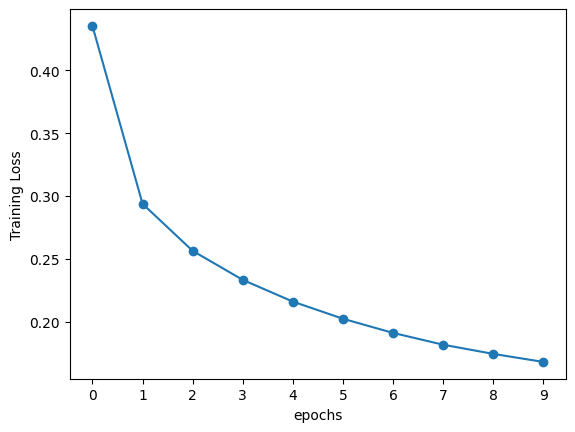

In [34]:
plot_metric_epochs(metric_values=logs_loss)

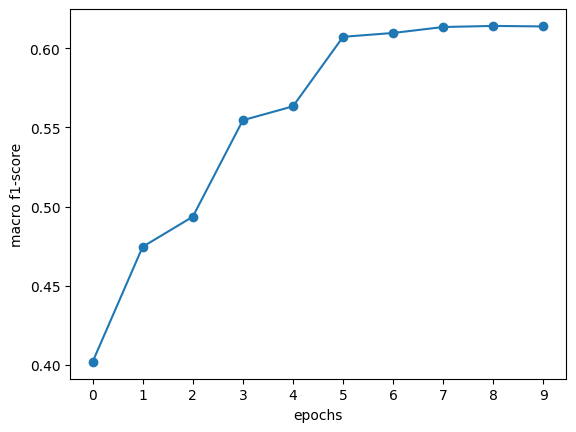

In [36]:
plot_metric_epochs(metric_values=logs_f1_score, y_label_name="macro f1-score")